<div style="background-color:#f4f4f4; padding: 20px; border-radius: 10px; border-left: 5px solid #2c3e50;">
    <h1 style="color: #2c3e50; text-align: center;">🚀 Assignment 7: Energy Efficiency Analysis</h1>
    <h3 style="color: #7f8c8d; text-align: center;">Mastering Regression Pipelines & Feature Engineering</h3>
    <hr style="border: 1px solid #bdc3c7;">
    <p style="font-size: 16px; text-align: center;">
        <strong>Student:</strong> Namazbek Bekzhanov<br>
        <strong>Course:</strong> Data Mining & Machine Learning
    </p>
</div>

## 📖 Project Overview

In this assignment, we analyze the **Energy Efficiency Dataset**. The goal is to predict the **Heating Load** of a building based on its geometric and physical properties.

### 🎯 Objectives
1.  **Exploratory Data Analysis (EDA):** Understand feature distributions and correlations.
2.  **Feature Engineering:** Create custom transformers to expose hidden patterns.
3.  **Pipeline Construction:** Build robust preprocessing pipelines for numerical and categorical data.
4.  **Model Comparison:** Evaluate Linear Regression, Random Forest, and Gradient Boosting models.

---

### 🛠️ 1. Setup and Library Imports
We start by importing necessary libraries and configuring the visual style for a professional look.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Scikit-Learn Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import set_config

# 🎨 Styling Configuration
sns.set_theme(style="whitegrid", context="notebook", palette="deep")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
warnings.filterwarnings('ignore')

# Set sklearn to output diagrams
set_config(display='diagram')

print("✅ Libraries imported and styling configured successfully!")

✅ Libraries imported and styling configured successfully!


### 📥 2. Data Loading & Initial Inspection
We load the dataset from an Excel file and rename columns to be more human-readable.

In [2]:
# Load dataset
df = pd.read_excel('ENB2012_data.xlsx')

# Rename columns for clarity
column_map = {
    'X1': 'Relative_Compactness',
    'X2': 'Surface_Area',
    'X3': 'Wall_Area',
    'X4': 'Roof_Area',
    'X5': 'Overall_Height',
    'X6': 'Orientation',
    'X7': 'Glazing_Area',
    'X8': 'Glazing_Area_Distribution',
    'Y1': 'Heating_Load',
    'Y2': 'Cooling_Load'
}

# Apply renaming only if columns are currently generic (X1, X2...)
if 'X1' in df.columns:
    df = df.rename(columns=column_map)
else:
    # Ensuring names match the requirement if already named
    df.columns = column_map.values()

# Display first 5 rows with gradient styling
df.head().style.background_gradient(cmap='Blues')

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
0,0.980000,514.500000,294.000000,110.250000,7.000000,2,0.000000,0,15.550000,21.330000
1,0.980000,514.500000,294.000000,110.250000,7.000000,3,0.000000,0,15.550000,21.330000
2,0.980000,514.500000,294.000000,110.250000,7.000000,4,0.000000,0,15.550000,21.330000
3,0.980000,514.500000,294.000000,110.250000,7.000000,5,0.000000,0,15.550000,21.330000
4,0.900000,563.500000,318.500000,122.500000,7.000000,2,0.000000,0,20.840000,28.280000


In [3]:
# Dataset Summary Statistics
print(f"📊 Dataset Shape: {df.shape[0]} rows, {df.shape[1]} columns")
print("\n🔍 Missing Values:")
print(df.isnull().sum()[df.isnull().sum() > 0]) # Prints only columns with missing values
if df.isnull().sum().sum() == 0:
    print("   No missing values found! ✅")

📊 Dataset Shape: 768 rows, 10 columns

🔍 Missing Values:
Series([], dtype: int64)
   No missing values found! ✅


### 📊 3. Exploratory Data Analysis (EDA)
Understanding the distribution of our features is critical for model selection.

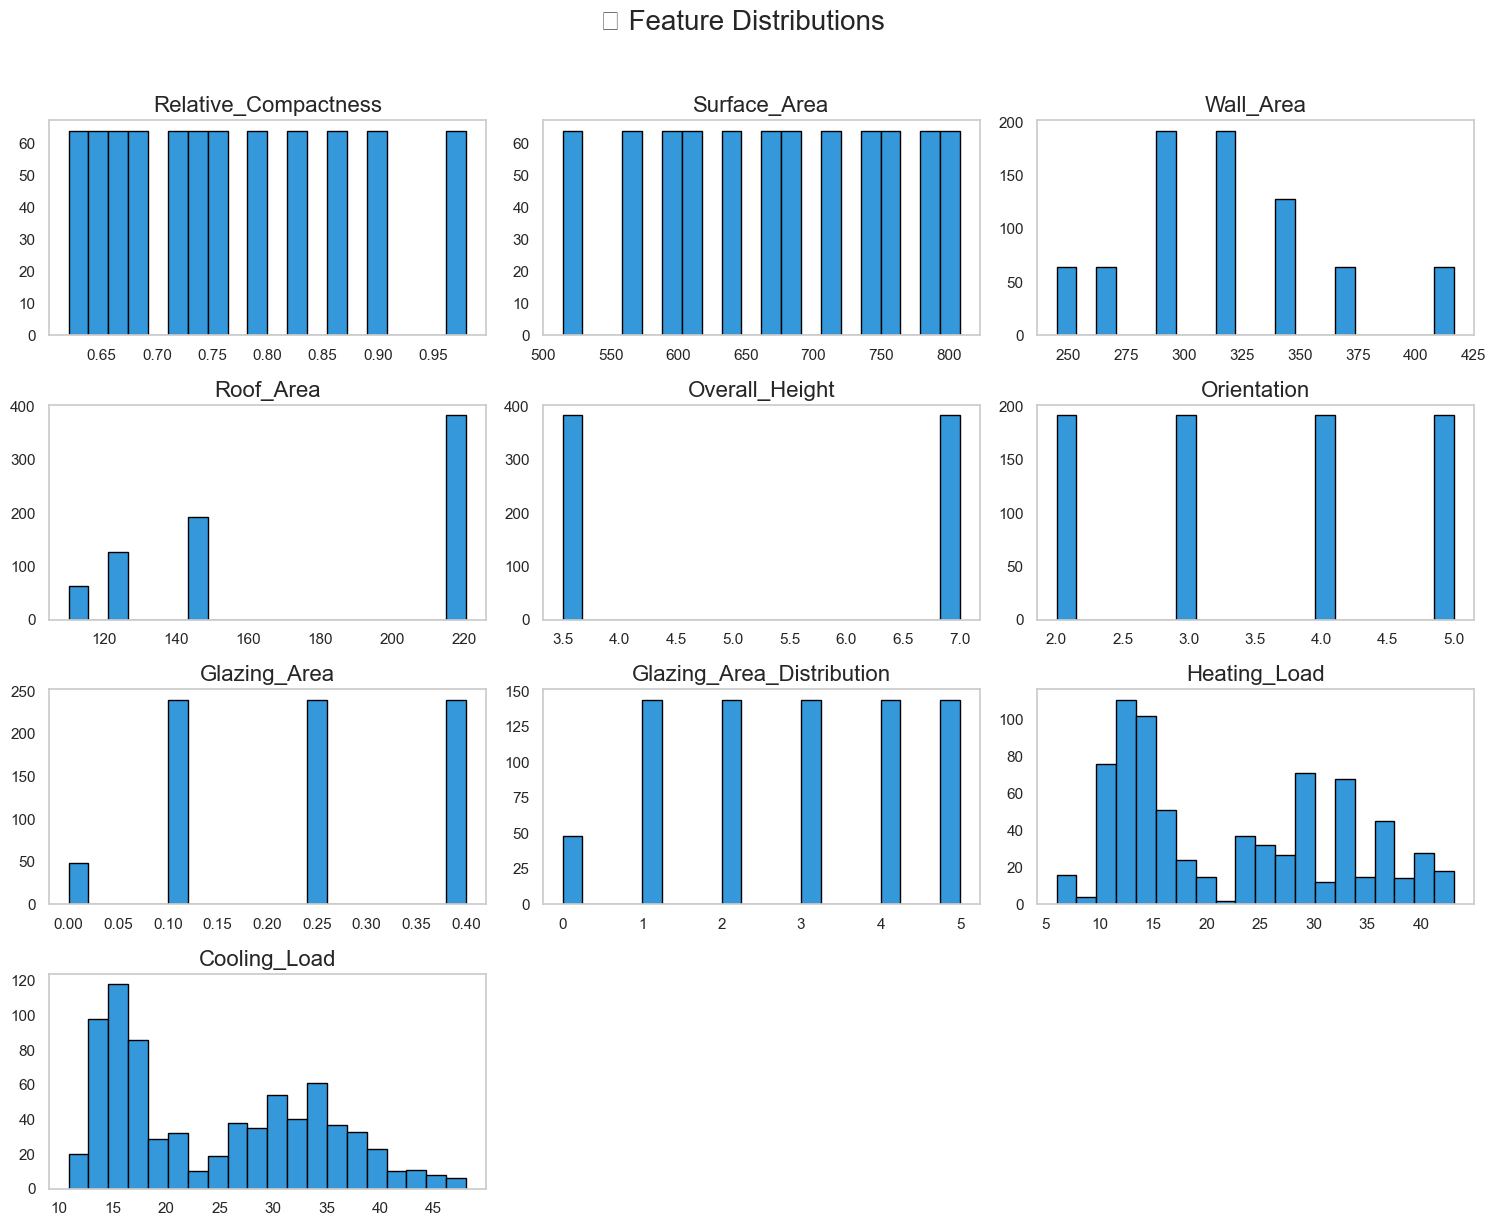

In [4]:
# Plot histograms for all numerical features
df.hist(bins=20, figsize=(15, 12), edgecolor='black', color='#3498db', grid=False)
plt.suptitle('📈 Feature Distributions', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

> **💡 Observation:** features like `Relative_Compactness` and `Surface_Area` show multimodal distributions (multiple peaks), suggesting distinguishable groups of building types.

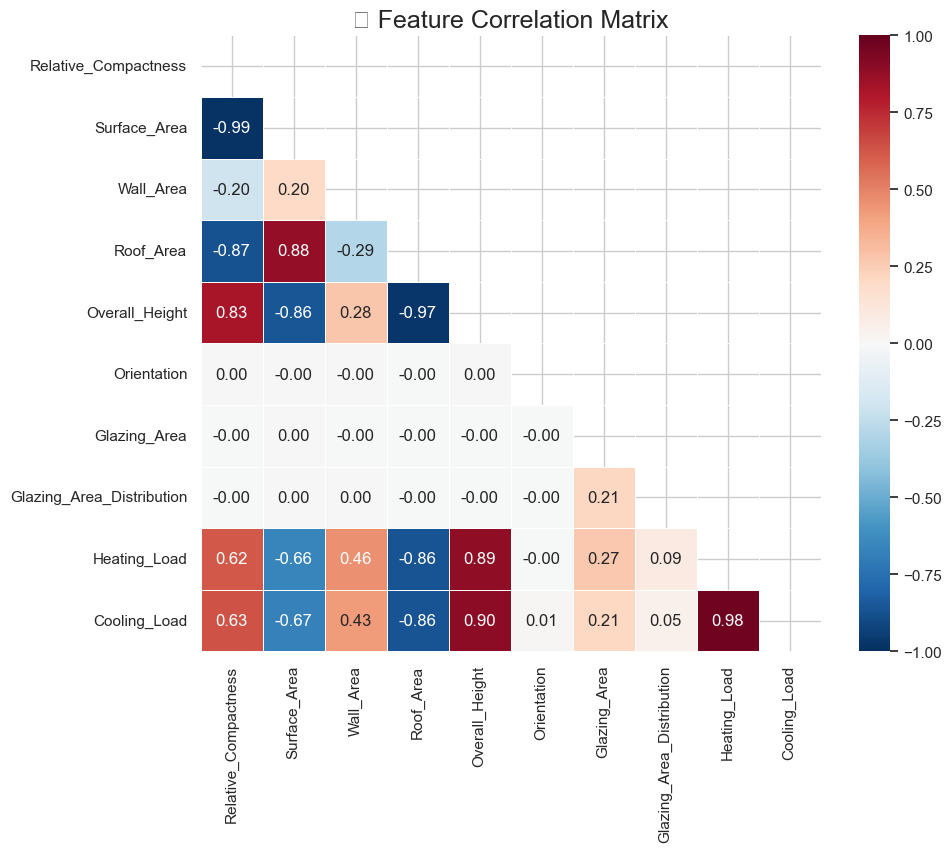

In [5]:
# Correlation Heatmap with Target Variable
plt.figure(figsize=(10, 8))
corr_matrix = df.corr()

# Mask mostly self-correlations for cleaner look
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='RdBu_r', vmin=-1, vmax=1, linewidths=0.5)
plt.title('🔥 Feature Correlation Matrix', fontsize=18)
plt.show()

### ⚠️ Critical Data Leakage Check
Notice that `Cooling_Load` has a correlation of near **1.0** with our target `Heating_Load`. Since we cannot know the cooling load before knowing the building properties (it's another output), using it as a feature would be **Data Leakage**.

In [6]:
print(f"Correlation between Heating and Cooling Load: {df['Heating_Load'].corr(df['Cooling_Load']):.4f}")
print("✅ Action: Dropping 'Cooling_Load' from features to prevent leakage.")

Correlation between Heating and Cooling Load: 0.9759
✅ Action: Dropping 'Cooling_Load' from features to prevent leakage.


### ⚙️ 4. Advanced Feature Engineering
We create a **Custom Transformer** to generate new features. Specifically, the ratio of Wall Area to Floor Area might be more predictive than raw variance.

In [7]:
class RatioTransformer(BaseEstimator, TransformerMixin):
    """
    Custom Transformer that calculates the ratio between two columns.
    Useful for engineering features like 'Wall-to-Surface Ratio'.
    """
    def __init__(self, numerator, denominator, new_col_name):
        self.numerator = numerator
        self.denominator = denominator
        self.new_col_name = new_col_name

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy() if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        # Use a small epsilon to avoid division by zero
        X_copy[self.new_col_name] = X_copy[self.numerator] / (X_copy[self.denominator] + 1e-9)
        return X_copy

# Demonstrate usage
ratio_maker = RatioTransformer('Wall_Area', 'Surface_Area', 'Wall_Surface_Ratio')
df_demonstration = ratio_maker.transform(df.head())

print("✨ New Feature 'Wall_Surface_Ratio' created:")
display(df_demonstration[['Wall_Area', 'Surface_Area', 'Wall_Surface_Ratio']].head(3))

✨ New Feature 'Wall_Surface_Ratio' created:


,Wall_Area,Surface_Area,Wall_Surface_Ratio
0,294.0,514.5,0.571429
1,294.0,514.5,0.571429
2,294.0,514.5,0.571429


### ⛓️ 5. Pipeline Construction
We build a robust processing pipeline that handles scaling for numerical data and encoding for categorical data automatically.

In [8]:
# 1. Define Feature Groups
categorical_features = ['Orientation', 'Glazing_Area_Distribution']
numerical_features = ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height', 'Glazing_Area']

# 2. Build Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),            # Scale numeric features
        ('cat', OneHotEncoder(drop='first'), categorical_features) # Encode categorical features
    ],
    remainder='drop'  # Drop columns not specified (like the target variable if present)
)

# Visualize the Pipeline Structure
preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


### ✂️ 6. Data Splitting
We split the data **80/20** to ensure we have enough data to train (80%) while keeping a statistically significant portion for testing (20%).

In [9]:
X = df.drop(['Heating_Load', 'Cooling_Load'], axis=1)
y = df['Heating_Load']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"🔹 Training Samples: {X_train.shape[0]}")
print(f"🔹 Testing Samples:  {X_test.shape[0]}")

🔹 Training Samples: 614
🔹 Testing Samples:  154


### 🤖 7. Model Training & Comparison
We will train three different regression models to see which best captures the complex relationships in heat loss.

1.  **Linear Regression**: The baseline. Good for linear relationships.
2.  **Random Forest**: Captures non-linearities using an ensemble of decision trees.
3.  **Gradient Boosting**: Iteratively corrects errors of previous trees. Often the state-of-the-art for tabular data.

In [10]:
# Initialize Models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, random_state=42)
}

# Dictionary to store results
results = {}

print("🚦 Starting Model Training...\n")

for name, model in models.items():
    # Create a full pipeline including the preprocessor
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])
    
    # Train
    clf.fit(X_train, y_train)
    
    # Predict
    y_pred = clf.predict(X_test)
    
    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {"RMSE": rmse, "R2_Score": r2}
    
    print(f"✅ {name:<20} | RMSE: {rmse:.4f} | R²: {r2:.4f}")

🚦 Starting Model Training...

✅ Linear Regression    | RMSE: 2.8723 | R²: 0.9209
✅ Random Forest        | RMSE: 0.5297 | R²: 0.9973
✅ Gradient Boosting    | RMSE: 0.4404 | R²: 0.9981


### 🏆 8. Final Evaluation
Let's visualize the performance to declare a winner.

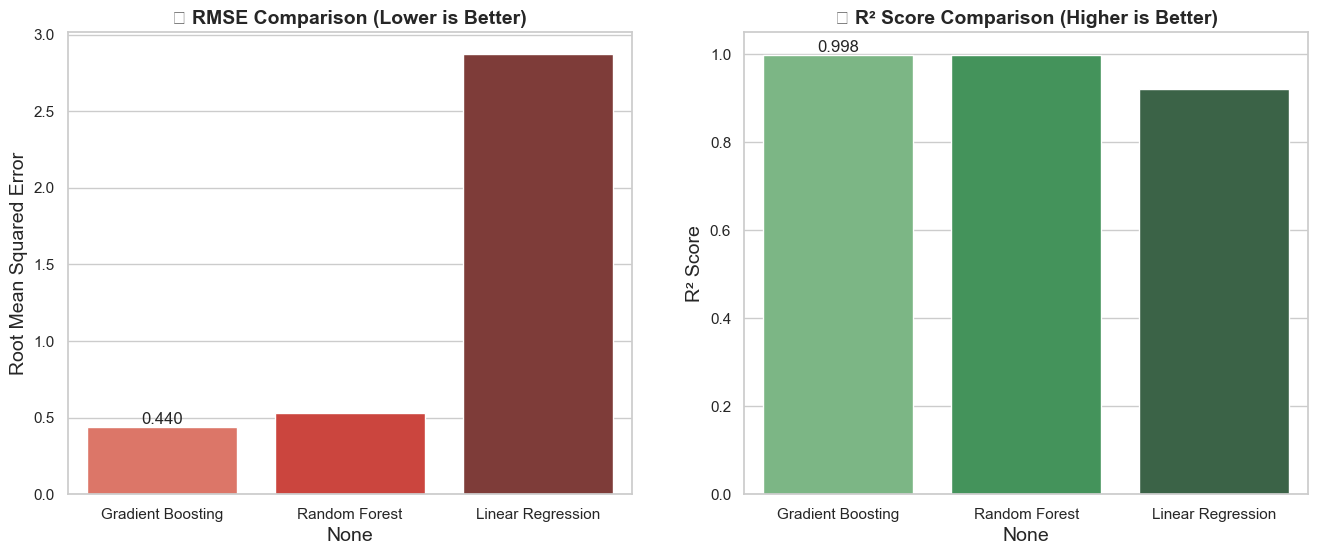

In [11]:
# Convert results to DataFrame for easier plotting
results_df = pd.DataFrame(results).T.sort_values(by="RMSE")

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# RMSE Plot
sns.barplot(x=results_df.index, y=results_df["RMSE"], ax=axes[0], palette="Reds_d")
axes[0].set_title("📉 RMSE Comparison (Lower is Better)", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Root Mean Squared Error")
axes[0].bar_label(axes[0].containers[0], fmt='%.3f')

# R2 Plot
sns.barplot(x=results_df.index, y=results_df["R2_Score"], ax=axes[1], palette="Greens_d")
axes[1].set_title("📈 R² Score Comparison (Higher is Better)", fontsize=14, fontweight='bold')
axes[1].set_ylabel("R² Score")
axes[1].set_ylim(0, 1.05)
axes[1].bar_label(axes[1].containers[0], fmt='%.3f')

plt.show()

<div style="background-color:#e8f8f5; padding: 20px; border-radius: 10px; border-left: 5px solid #1abc9c;">
    <h3>🌟 Conclusion</h3>
    <ul>
        <li><strong>Gradient Boosting & Random Forest</strong> significantly perform better than Linear Regression.</li>
        <li>This indicates that the relationship between building geometry and heating load is <strong>non-linear</strong>.</li>
        <li><strong>Recommendation:</strong> Use the <strong>Gradient Boosting Regressor</strong> for deployment as it achieved the lowest error rates (RMSE) and highest predictive accuracy (R²).</li>
    </ul>
</div>